In [1]:
from src.dataloader import *

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets


# Import des données

Terminologie:
* 1 epoch = un forward et un backward pass sur les individus tirés
* batch size = nombre d'individus de l'échantillon d'apprentissage dans un forward/backward pass. Plus le batck size est élevé, plus il faut de mémoire
* number of iterations = nombre de passes, chaque pass utilisant [batch size] number of examples. 
  1 pass = 1 forward pass + 1 backward pass (we do not count the forward pass and backward pass as two different passes).

Exemple: si j'ai 1000 individus dans l'échantillon d'apprentissage, et que batch_size=500.
* 1st pass: 500 individus tirés pour le forward
* 2nd pass: 500 individus tirés pour le backward

Donc, il faut 2 itérations pour réaliser un epoch.

In [2]:
label_attribution=LabelAttribution(path_image_google="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", 
                                   path_mask_google='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/mask/',
                                   path_metadata='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                   path_image_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img',
                                   path_mask_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/mask/',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [3]:
label_attribution.run()

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. 

In [4]:
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor()
                                           ]))
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                                transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))

In [5]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [6]:
transformed_train_dataset.__getitem__(0)[0]

tensor([[[0.2118, 0.1020, 0.1176,  ..., 0.4196, 0.4000, 0.4353],
         [0.1882, 0.1412, 0.1294,  ..., 0.4353, 0.4588, 0.5412],
         [0.2431, 0.2196, 0.2275,  ..., 0.4549, 0.4157, 0.2392],
         ...,
         [0.2392, 0.1255, 0.1020,  ..., 0.1137, 0.1137, 0.1255],
         [0.2706, 0.2431, 0.2588,  ..., 0.1020, 0.0980, 0.1137],
         [0.2980, 0.3412, 0.3843,  ..., 0.1647, 0.1843, 0.1647]],

        [[0.2392, 0.1255, 0.1529,  ..., 0.4275, 0.4392, 0.4784],
         [0.2196, 0.1608, 0.1529,  ..., 0.4392, 0.4706, 0.5647],
         [0.2902, 0.2549, 0.2706,  ..., 0.4588, 0.4275, 0.2745],
         ...,
         [0.3098, 0.1569, 0.1137,  ..., 0.1176, 0.1098, 0.1216],
         [0.3294, 0.2471, 0.2667,  ..., 0.1059, 0.0980, 0.1098],
         [0.3451, 0.3490, 0.3922,  ..., 0.1647, 0.1843, 0.1647]],

        [[0.1882, 0.0941, 0.1098,  ..., 0.3922, 0.3569, 0.4039],
         [0.1608, 0.1216, 0.1098,  ..., 0.4078, 0.4353, 0.5412],
         [0.2078, 0.1882, 0.1961,  ..., 0.4314, 0.3922, 0.

In [7]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 28, 28])


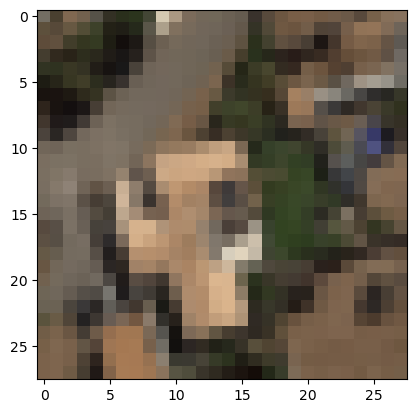

Label: 1


In [8]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[2].squeeze()
label = train_labels[2]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

On normalise aussi les images: pour chaque chaque channel d'un tenseur, on met la moyenne à 0 et la variance à 1.


output[channel] = (input[channel] - mean[channel]) / std[channel]

In [9]:
mean, std = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean))
print("Ecart-type par channel: {}".format(std))

Moyenne par channel: tensor([0.3329, 0.3431, 0.2972])
Ecart-type par channel: tensor([0.1565, 0.1396, 0.1371])


Comme on a utilisé des batches, les moyennes et écart-types calculés précédemment sont faux. On utilise, le code suivant.

In [10]:
mean, std = batch_mean_and_sd(train_dataloader)
print("Moyenne par channel: {}".format(mean))
print("Ecart-type par channel: {}".format(std))

Moyenne par channel: tensor([0.3493, 0.3566, 0.3072])
Ecart-type par channel: tensor([0.1662, 0.1475, 0.1456])


On normalise les données. On ajoute aussi des rotations horizontales aléatoires. Avec probabilité 0.5, l'image est retournée.

In [11]:
normalized_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3493,0.3566,0.3072],
                                                                    std= [0.1662,0.1475,0.1456]),
                                               transforms.RandomHorizontalFlip(),
                                           ]))

train_dataloader = DataLoader(normalized_train_dataset, batch_size=64, shuffle=True)
